In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
from magic_pen.config import *


In [35]:
image = cv2.imread(str(sam_data_path / 'truck.jpg'))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [36]:
image.shape

(1200, 1800, 3)

In [2]:
def build_point_grid(n_per_side: int) -> np.ndarray:
    """Generates a 2D grid of points evenly spaced in [0,1]x[0,1]."""
    offset = 1 / (2 * n_per_side)
    points_one_side = np.linspace(offset, 1 - offset, n_per_side)
    points_x = np.tile(points_one_side[None, :], (n_per_side, 1))
    points_y = np.tile(points_one_side[:, None], (1, n_per_side))
    points = np.stack([points_x, points_y], axis=-1).reshape(-1, 2)
    return points

In [3]:
grid = build_point_grid(32)

In [5]:
grid.shape

(1024, 2)

In [13]:
grid

array([[0.015625, 0.015625],
       [0.046875, 0.015625],
       [0.078125, 0.015625],
       ...,
       [0.921875, 0.984375],
       [0.953125, 0.984375],
       [0.984375, 0.984375]])

In [6]:
n_per_side = 32
offset = 1 / (2 * n_per_side)
points_one_side = np.linspace(offset, 1 - offset, n_per_side)

In [7]:
points_one_side

array([0.015625, 0.046875, 0.078125, 0.109375, 0.140625, 0.171875,
       0.203125, 0.234375, 0.265625, 0.296875, 0.328125, 0.359375,
       0.390625, 0.421875, 0.453125, 0.484375, 0.515625, 0.546875,
       0.578125, 0.609375, 0.640625, 0.671875, 0.703125, 0.734375,
       0.765625, 0.796875, 0.828125, 0.859375, 0.890625, 0.921875,
       0.953125, 0.984375])

In [10]:
np.tile(points_one_side[None, :], (n_per_side, 1))

array([[0.015625, 0.046875, 0.078125, ..., 0.921875, 0.953125, 0.984375],
       [0.015625, 0.046875, 0.078125, ..., 0.921875, 0.953125, 0.984375],
       [0.015625, 0.046875, 0.078125, ..., 0.921875, 0.953125, 0.984375],
       ...,
       [0.015625, 0.046875, 0.078125, ..., 0.921875, 0.953125, 0.984375],
       [0.015625, 0.046875, 0.078125, ..., 0.921875, 0.953125, 0.984375],
       [0.015625, 0.046875, 0.078125, ..., 0.921875, 0.953125, 0.984375]])

In [12]:
np.tile(points_one_side[:, None], (1, n_per_side))

array([[0.015625, 0.015625, 0.015625, ..., 0.015625, 0.015625, 0.015625],
       [0.046875, 0.046875, 0.046875, ..., 0.046875, 0.046875, 0.046875],
       [0.078125, 0.078125, 0.078125, ..., 0.078125, 0.078125, 0.078125],
       ...,
       [0.921875, 0.921875, 0.921875, ..., 0.921875, 0.921875, 0.921875],
       [0.953125, 0.953125, 0.953125, ..., 0.953125, 0.953125, 0.953125],
       [0.984375, 0.984375, 0.984375, ..., 0.984375, 0.984375, 0.984375]])

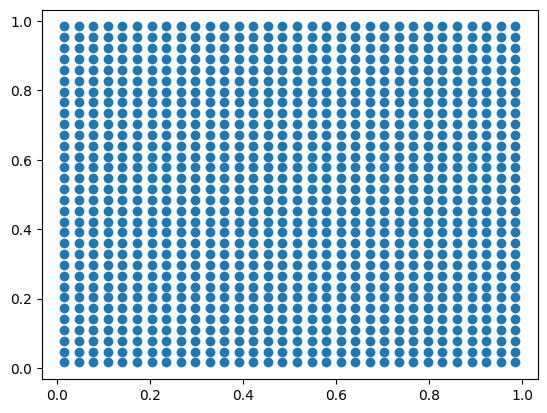

In [17]:
plt.scatter(grid[:, 0], grid[:, 1])

### Generation masks

In [49]:
from typing import Tuple, Any, Dict, List
import math
from itertools import product

def generate_crop_boxes(
    im_size: Tuple[int, ...], n_layers: int, overlap_ratio: float
) -> Tuple[List[List[int]], List[int]]:
    """
    Generates a list of crop boxes of different sizes. Each layer
    has (2**i)**2 boxes for the ith layer.
    """
    crop_boxes, layer_idxs = [], []
    im_h, im_w = im_size
    short_side = min(im_h, im_w)

    # Original image
    crop_boxes.append([0, 0, im_w, im_h])
    layer_idxs.append(0)

    def crop_len(orig_len, n_crops, overlap):
        return int(math.ceil((overlap * (n_crops - 1) + orig_len) / n_crops))

    for i_layer in range(n_layers):
        n_crops_per_side = 2 ** (i_layer + 1)
        overlap = int(overlap_ratio * short_side * (2 / n_crops_per_side))

        crop_w = crop_len(im_w, n_crops_per_side, overlap)
        crop_h = crop_len(im_h, n_crops_per_side, overlap)

        crop_box_x0 = [int((crop_w - overlap) * i) for i in range(n_crops_per_side)]
        crop_box_y0 = [int((crop_h - overlap) * i) for i in range(n_crops_per_side)]

        # Crops in XYWH format
        for x0, y0 in product(crop_box_x0, crop_box_y0):
            box = [x0, y0, min(x0 + crop_w, im_w), min(y0 + crop_h, im_h)]
            crop_boxes.append(box)
            layer_idxs.append(i_layer + 1)

    return crop_boxes, layer_idxs

In [139]:
# default
im_size = (1024, 1024)
n_layers = 2
overlap_ratio = 512/1500

In [140]:
crop_boxes, layer_idx = generate_crop_boxes(im_size, n_layers, overlap_ratio)

In [141]:
crop_boxes

[[0, 0, 1024, 1024],
 [0, 0, 687, 687],
 [0, 338, 687, 1024],
 [338, 0, 1024, 687],
 [338, 338, 1024, 1024],
 [0, 0, 387, 387],
 [0, 213, 387, 600],
 [0, 426, 387, 813],
 [0, 639, 387, 1024],
 [213, 0, 600, 387],
 [213, 213, 600, 600],
 [213, 426, 600, 813],
 [213, 639, 600, 1024],
 [426, 0, 813, 387],
 [426, 213, 813, 600],
 [426, 426, 813, 813],
 [426, 639, 813, 1024],
 [639, 0, 1024, 387],
 [639, 213, 1024, 600],
 [639, 426, 1024, 813],
 [639, 639, 1024, 1024]]

In [142]:
im_bbox = [crop_boxes[0][:2]] + crop_boxes[0][2:]
boxes = []
for rec in crop_boxes[1:]:
    h = rec[2] - rec[0]
    w = rec[3] - rec[1]
    boxes.append([rec[:2]] + [w, h])



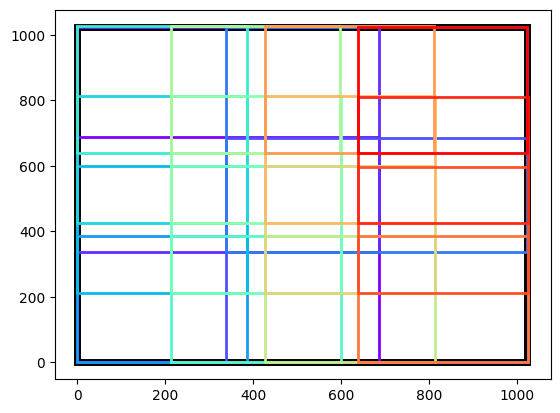

In [143]:
from matplotlib.patches import Rectangle

colors = plt.cm.rainbow(np.linspace(0, 1, len(boxes)))

fig, ax = plt.subplots()

#create simple line plot
ax.plot()

#add rectangle to plot
ax.add_patch(Rectangle(*im_bbox,
             edgecolor = 'black',
             fill=False,
             lw=5))
for bbox,c in zip(boxes, colors):
    #add rectangle to plot
    ax.add_patch(Rectangle(*bbox,
                 edgecolor = c,
                 fill=False,
                 lw=2))


## Test SegmentAnyChange

In [1]:
from magic_pen.seg_any_change.main import SegAnyChange
from magic_pen.config import *
from magic_pen.io import *
from magic_pen.seg_any_change.utils import *

/home/MDizier/miniforge3/envs/magic_pen/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
pair_img = load_levircd_sample(1, seed=42)
path_label,path_A, path_B = pair_img.iloc[0]

In [3]:
segany = SegAnyChange(
    img_A=load_img(path_A),
    img_B=load_img(path_B),
    model_type="vit_b"
)

In [4]:
%%time
res = segany.bitemporal_matching()

CPU times: user 6.2 s, sys: 3.04 s, total: 9.24 s
Wall time: 9.24 s


In [5]:
mask_A, img_embedding_A = res["A"].values()
mask_B, img_embedding_B = res["B"].values()

In [6]:
img_embedding_A.shape

(256, 64, 64)

In [8]:
i_emb = img_embedding_A.copy()

In [9]:
i_emb.shape

(256, 64, 64)

In [13]:
bm = mask_A[0]

/home/MDizier/miniforge3/envs/magic_pen/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


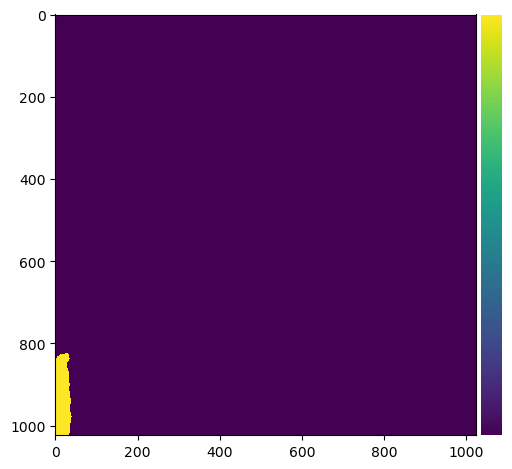

In [15]:
show_img(bm)

In [22]:
bm

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=uint8)

In [16]:
bm_resh = bm.reshape(256, 64, 64)

In [17]:
bm_resh.shape

(256, 64, 64)

In [26]:
m_emb = [np.mean((i_emb*bm.reshape(256, 64, 64)), axis=(1, 2)) for bm in mask_A]

#### Match binary mask 1024x1024 to embedding image (256x64x64):
* resize image to 256x1024x1024 (interpolation)
* reshape mask to 256x64x64 and product element wise and sum => 256